I want to compare the results that I have obtained in predicting the Apple stock prices with LSTM with the ones here below obtained by using ARIMA models

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
df = pd.read_csv('AAPL_training.csv', index_col='Date')

In [29]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-31,18.233213,19.121429,18.178572,19.006071,16.541204,659492400
2013-01-02,19.779285,19.821428,19.343929,19.608213,17.065252,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.849854,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.380503,594333600
2013-01-07,18.642857,18.903572,18.400000,18.710714,16.284145,484156400


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1260 entries, 2012-12-31 to 2017-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1260 non-null   float64
 1   High       1260 non-null   float64
 2   Low        1260 non-null   float64
 3   Close      1260 non-null   float64
 4   Adj Close  1260 non-null   float64
 5   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9+ KB


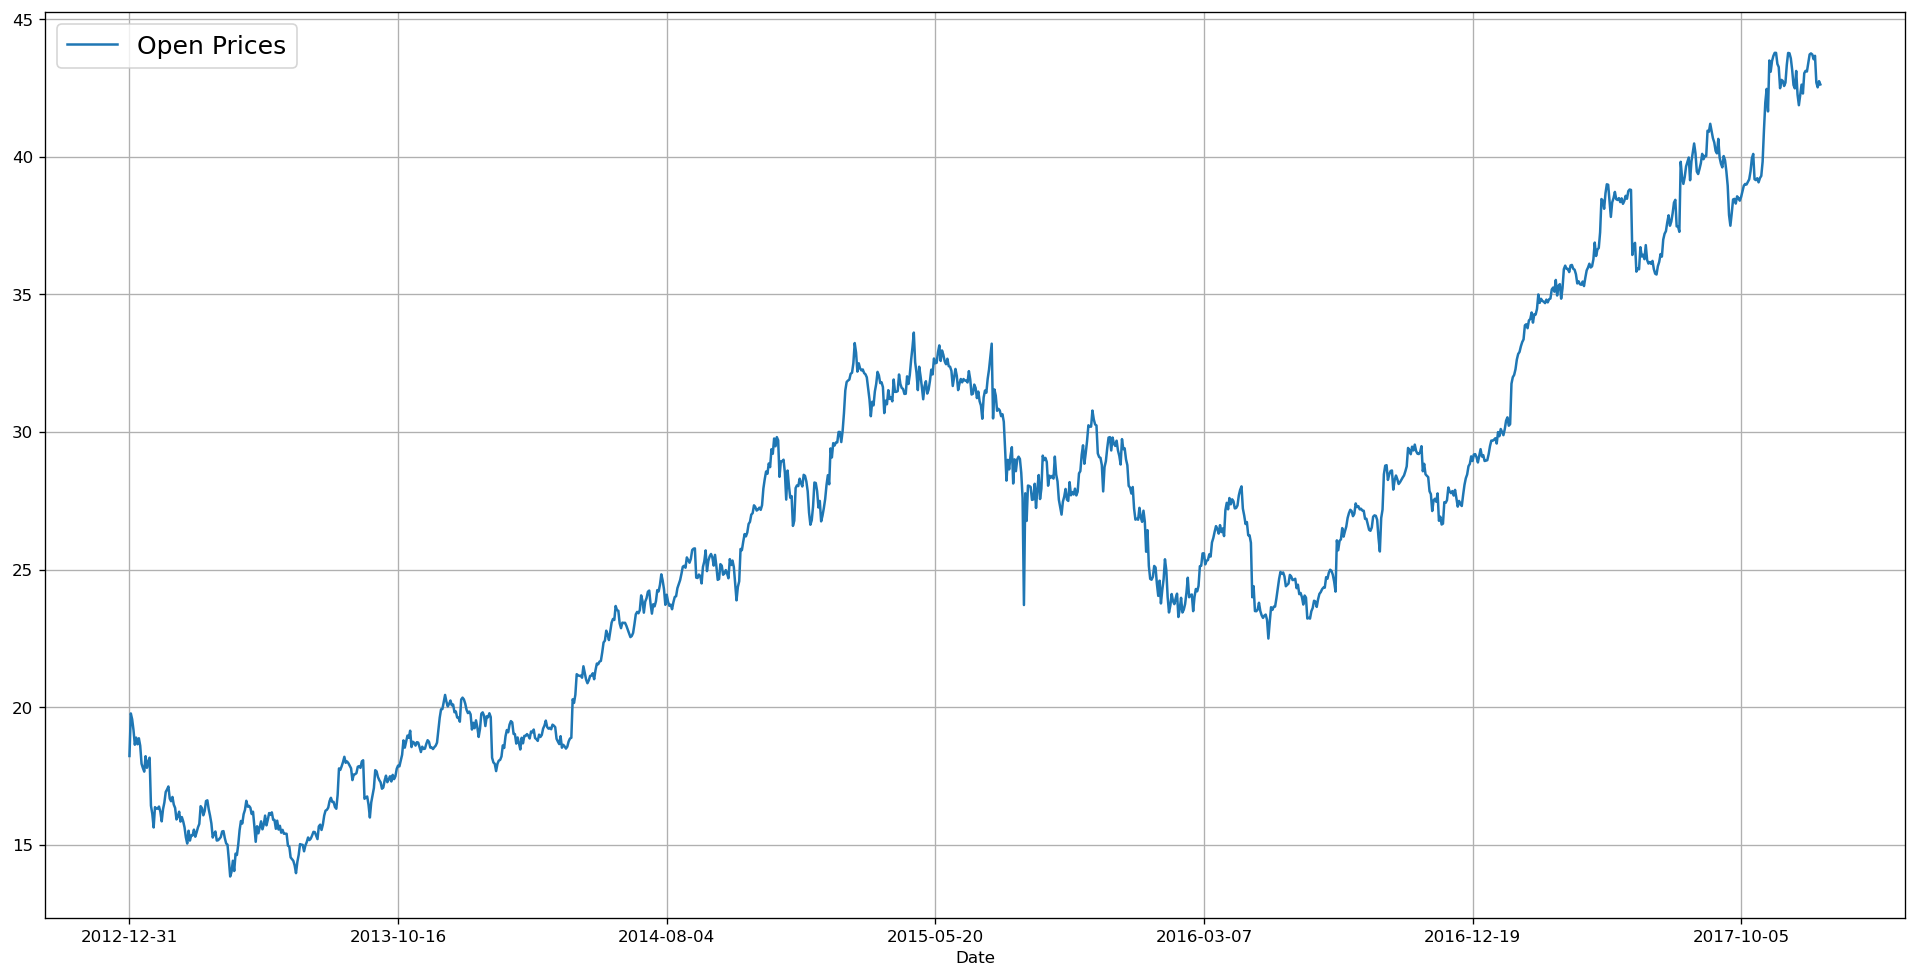

In [31]:
plt.figure(figsize=(20,10))
df['Open'].plot(label='Open Prices')
plt.grid(True)
plt.legend(loc=2, fontsize=15)

Let's check stationarity, by using ADF test. H_0 is that the time series is non stationary. If the p-value is less than 0.05, we reject H_0; the time series is already stationary.

In [32]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [33]:
result = adfuller(df.Open)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.132854
p-value: 0.968234


p-value is way bigger than 5%, we keep H_0 and therefore the data are non-stationary. We need to difference it

In [34]:
df.keys()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [35]:
df.drop(['High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [36]:
df.head()

,Open
Date,
2012-12-31,18.233213
2013-01-02,19.779285
2013-01-03,19.567142
2013-01-04,19.177500
2013-01-07,18.642857


In [37]:
df.diff().dropna()

,Open
Date,
2013-01-02,1.546072
2013-01-03,-0.212143
2013-01-04,-0.389642
2013-01-07,-0.534643
2013-01-08,0.257499
...,...
2017-12-22,0.127498
2017-12-26,-0.969997
2017-12-27,-0.174999


In [38]:
df.Open.diff().dropna()

Date
2013-01-02    1.546072
2013-01-03   -0.212143
2013-01-04   -0.389642
2013-01-07   -0.534643
2013-01-08    0.257499
                ...   
2017-12-22    0.127498
2017-12-26   -0.969997
2017-12-27   -0.174999
2017-12-28    0.224998
2017-12-29   -0.119999
Name: Open, Length: 1259, dtype: float64

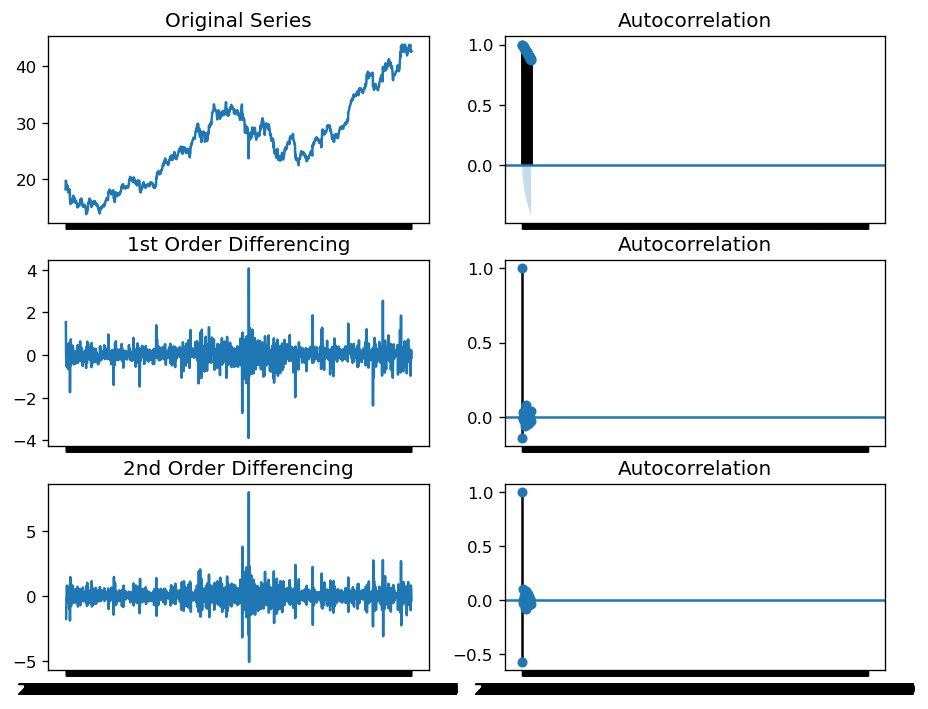

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.Open); axes[0, 0].set_title('Original Series')
plot_acf(df.Open, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Open.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Open.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.Open.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Open.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

I would go for just one order of differencing, so d=1

In [40]:
from pandas.plotting import autocorrelation_plot

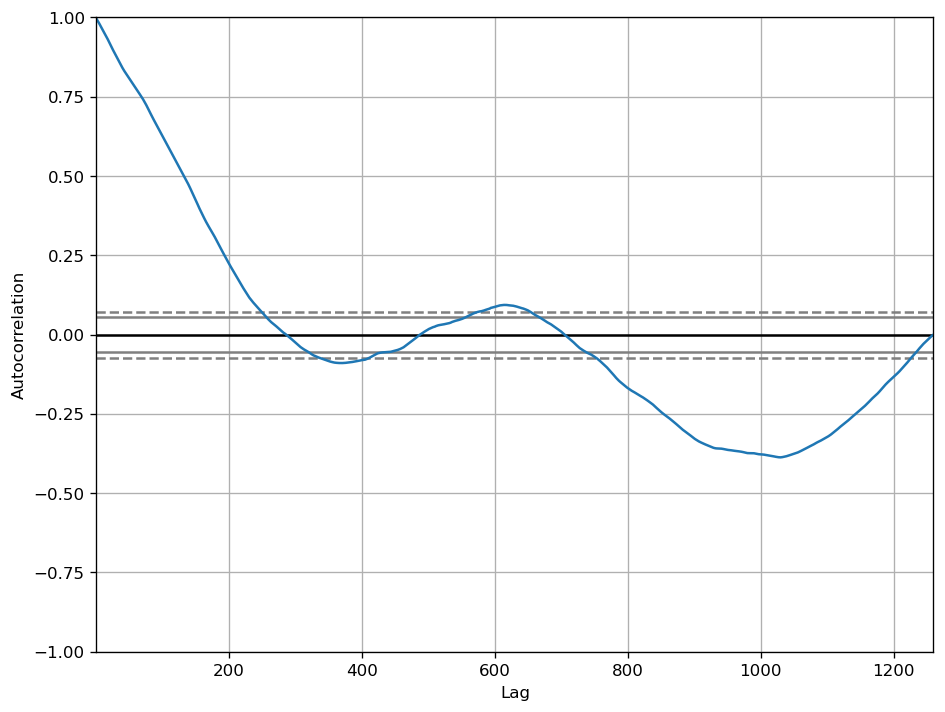

In [41]:
autocorrelation_plot(df)

We need to fix the value of autoregressive variables. ARIMA(p,d,q). We won't consider seasonal effects, I can't see any reson for that. So no SARIMA.

We check first by using the partial autocororrelation sulla 1-order differenced series, and see what happens.

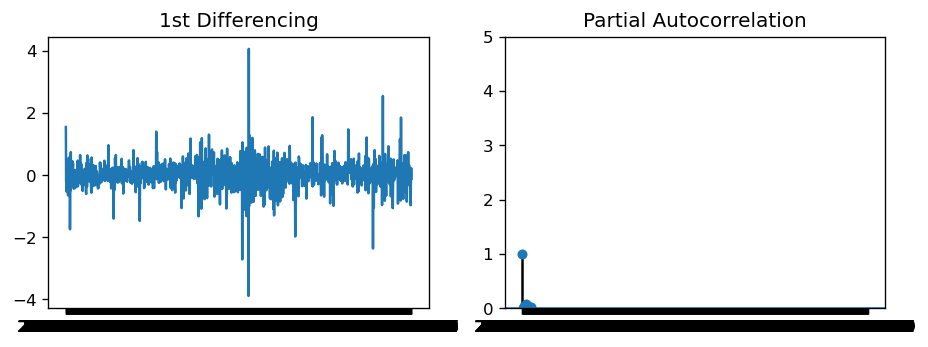

In [42]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.Open.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.Open.diff().dropna(), ax=axes[1])

plt.show()

Not very clear why the graph of the autocorelation works like that. Let's try differently.

In [46]:
from statsmodels.graphics.tsaplots import plot_acf

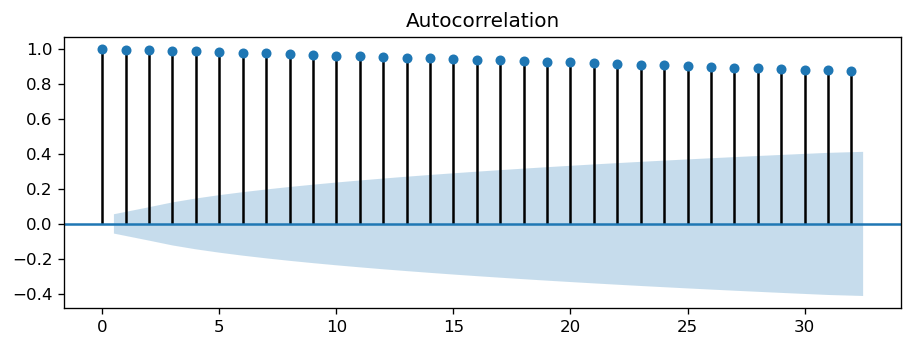

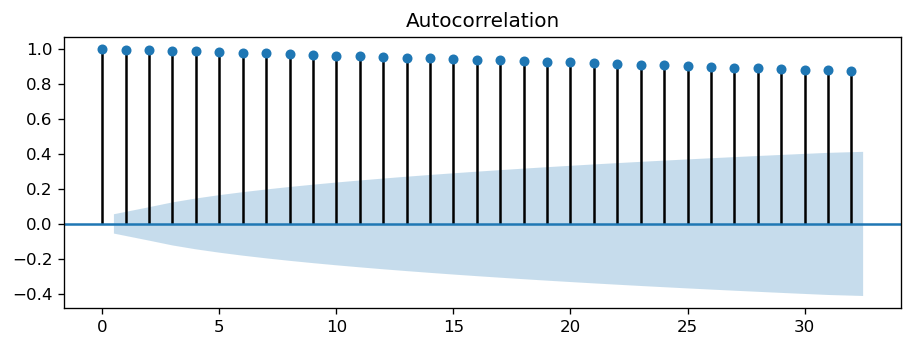

In [47]:
plot_acf(df.Open) 

it's using the Pearson'coefficient to detect the corroletation between a variable and the previous (in time) variables. The confidence interval are drown in the cone.  By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke. Quite a lot, since the x-axis represents the lags.

The Partial Autocorrelation (PARC) is instead the correlation with the variable at the time t with the one of the time t-k, only that one. Therefore the partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

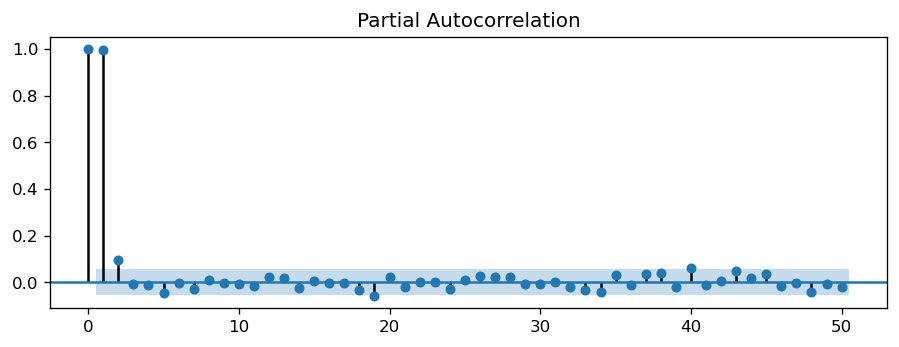

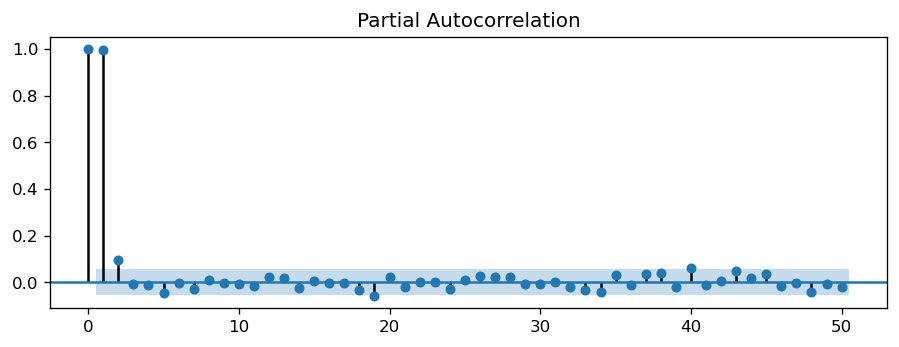

In [48]:
plot_pacf(df.Open, lags=50)

How to read the PARC? 

1. Large spike at lag 1 that decreases after a few lags: A moving average term in the data. Use the autocorrelation function to determine the order of the moving average term.	

2. Large spike at lag 1 followed by a damped wave that alternates between positive and negative correlations :A higher order moving average term in the data. Use the autocorrelation function to determine the order of the moving average term.	

3. Significant correlations at the first or second lag, followed by correlations that are not significant :An autoregressive term in the data. The number of significant correlations indicate the order of the autoregressive term.




From above, I would set p = 2, d = 1, q = 0, and therefore I would use an ARIMA (2,1,0). However, let's use a package that helps me to run among different ARIMA solutions, even though I need to set an upper bound for the hyperparameters. (I will use p,q <= 5)

In [49]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(df.Open, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1453.152, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1475.679, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1451.400, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1452.500, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1476.186, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1453.177, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1454.940, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1452.696, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.681 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1260
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -722.700
Date:                Tue, 02 Mar 2021   AIC                           1451.400
Time:                        15:38:4

It's suggesting me ARIMA(1,1,0), so a bit more conservative to my idea of using ARIMA(2,1,0). Let's go with ARIMA(1,1,0). Note above that Prob(Q)>\alpha and also H>\alpha, so in both cases, I would keep the H_0 hypothesis (which are respectively: 1. data are independent and not correlated (i.e. any correlation is just random. 2. Residuals have costant variance, so there is no Heteroskedasticity)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 1259
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -722.700
Method:                       css-mle   S.D. of innovations              0.430
Date:                Tue, 02 Mar 2021   AIC                           1451.400
Time:                        15:47:02   BIC                           1466.815
Sample:                             1   HQIC                          1457.193
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0192      0.011      1.818      0.069      -0.001       0.040
ar.L1.D.Open    -0.1444      0.028     -5.153      0.000      -0.199      -0.089
                                    Roots   

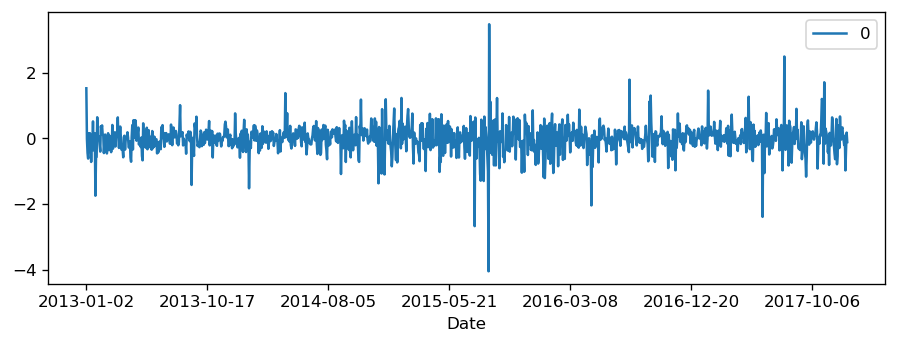

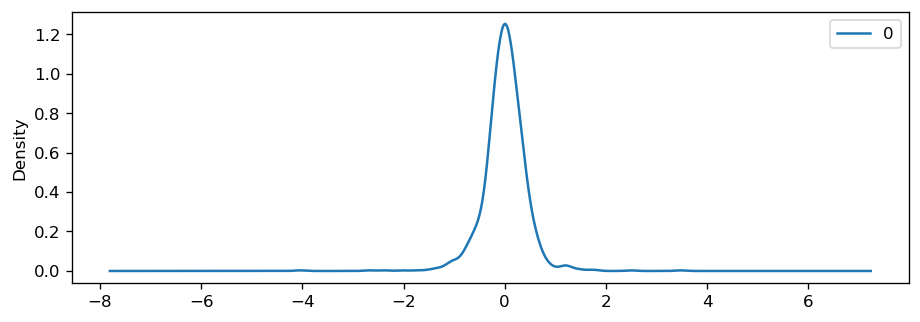

In [50]:
#df is my training set already. I fit the model with this one.

model = ARIMA(df, order=(1,1,0))
model_fit = model.fit()

print(model_fit.summary())


residuals = pd.DataFrame(model_fit.resid)
residuals.plot()


residuals.plot(kind='kde')


print(residuals.describe())

ok, seems good, especially the normality of the residuals.

### forecasting with ARIMA

We need to upload the other datasets for the predictions of the following 2 months of Apple stocks price.

In [52]:
df2 = pd.read_csv('AAPL_test.csv', index_col='Date')
df2.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.442081,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.434864,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.627323,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,42.101261,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.944889,82271200


In [53]:
df2.keys()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [54]:
df2.drop(['High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [55]:
df2.head()

,Open
Date,
2018-01-02,42.540001
2018-01-03,43.132500
2018-01-04,43.134998
2018-01-05,43.360001
2018-01-08,43.587502


In [57]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [58]:
len(df2)

20

In [59]:
len(df)

1260

In [65]:
X = df.values
Y = df2.values
train, test = X, Y
history = [x for x in train]
predictions = list()

#walk-forward validation (rollin forecasting)
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
#evaluate the forecasts
RMSE = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % RMSE)


predicted=42.669343, expected=42.540001
predicted=42.574901, expected=43.132500
predicted=43.069206, expected=43.134998
predicted=43.157046, expected=43.360001
predicted=43.350076, expected=43.587502
predicted=43.577448, expected=43.637501
predicted=43.653093, expected=43.290001
predicted=43.362626, expected=43.647499
predicted=43.618535, expected=44.044998
predicted=44.010817, expected=44.474998
predicted=44.436807, expected=44.037498
predicted=44.123614, expected=44.842499
predicted=44.749189, expected=44.652500
predicted=44.703827, expected=44.325001
predicted=44.395947, expected=44.325001
predicted=44.348284, expected=44.312500
predicted=44.337571, expected=43.627499
predicted=43.749628, expected=43.000000
predicted=43.111761, expected=42.540001
predicted=42.626630, expected=41.382500
Test RMSE: 0.491


Note that we did a rolling forecast, which is required given the dependence on observations in prior time steps for differencing and the AR model. But we did in a crude way: to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

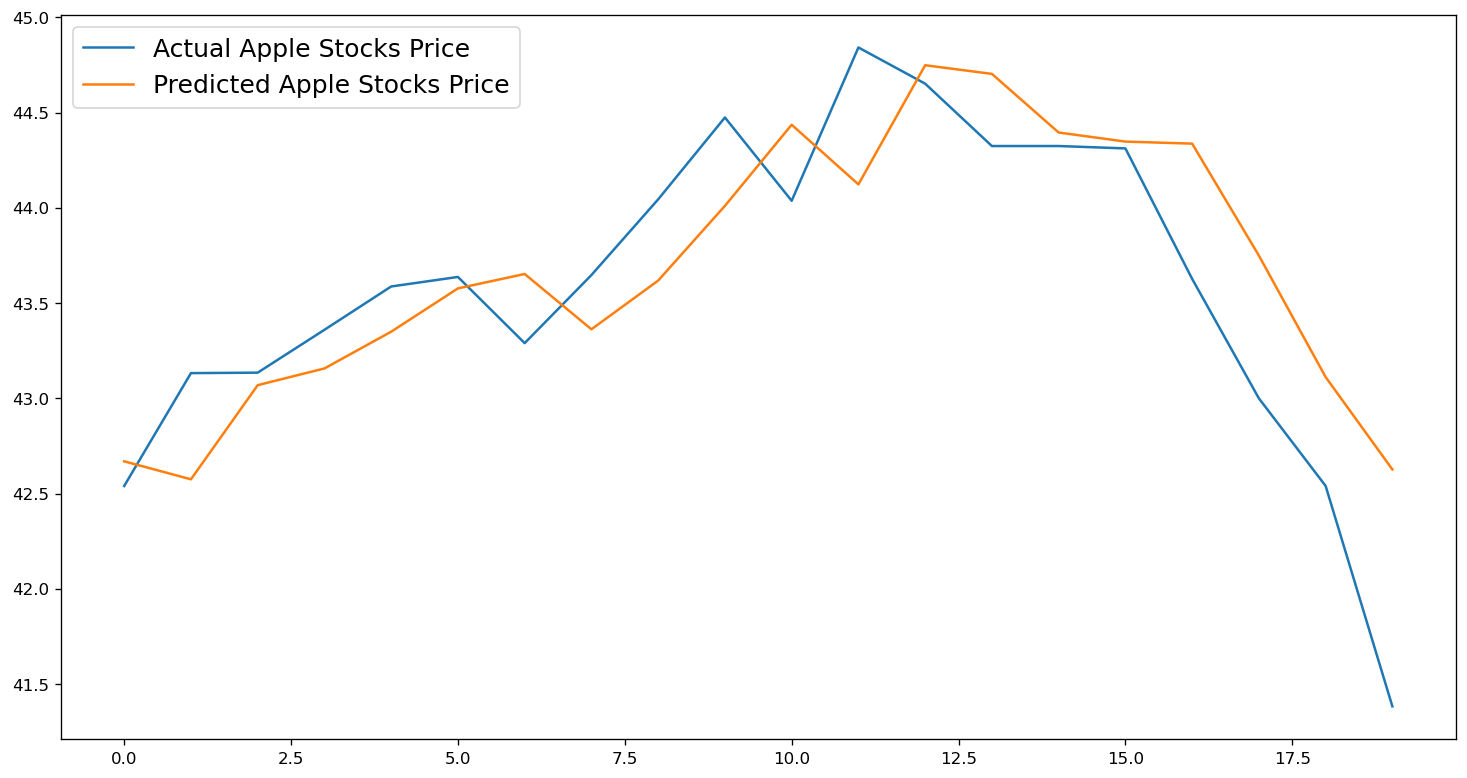

In [67]:
plt.figure(figsize=[15,8])
plt.plot(test, label='Actual Apple Stocks Price')
plt.plot(predictions, label='Predicted Apple Stocks Price')
plt.legend(loc=2, fontsize=15)